In [ ]:
import torch
import numpy as np

#hello justin
# ==========================================================================
# Utility Functions for Logic Operations
# ==========================================================================

def bin_op(a, b, i):
    """Implement the i-th binary logic operation between a and b."""
    if i == 0:  # 0 (False)
        return torch.zeros_like(a)
    elif i == 1:  # AND
        return a * b
    elif i == 2:  # A AND (NOT B)
        return a - a * b
    elif i == 3:  # A
        return a
    elif i == 4:  # (NOT A) AND B
        return b - a * b
    elif i == 5:  # B
        return b
    elif i == 6:  # XOR
        return a + b - 2 * a * b
    elif i == 7:  # OR
        return a + b - a * b
    elif i == 8:  # NOR
        return 1 - (a + b - a * b)
    elif i == 9:  # XNOR
        return 1 - (a + b - 2 * a * b)
    elif i == 10:  # NOT B
        return 1 - b
    elif i == 11:  # A OR (NOT B)
        return 1 - b + a * b
    elif i == 12:  # NOT A
        return 1 - a
    elif i == 13:  # (NOT A) OR B
        return 1 - a + a * b
    elif i == 14:  # NAND
        return 1 - a * b
    elif i == 15:  # 1 (True)
        return torch.ones_like(a)


def bin_op_s(a, b, i_s):
    """Compute weighted sum of all 16 binary operations."""
    r = torch.zeros_like(a)
    for i in range(16):
        u = bin_op(a, b, i)
        r = r + i_s[..., i] * u
    return r


def get_unique_connections(in_dim, out_dim, device='cuda'):
    """Create connection pattern that ensures each input is used."""
    assert out_dim * 2 >= in_dim, 'Neurons must be at least half of inputs'

    x = torch.arange(in_dim).long().unsqueeze(0)

    # Take pairs (0, 1), (2, 3), (4, 5), ...
    a, b = x[..., ::2], x[..., 1::2]
    if a.shape[-1] != b.shape[-1]:
        m = min(a.shape[-1], b.shape[-1])
        a = a[..., :m]
        b = b[..., :m]

    # If needed, take pairs (1, 2), (3, 4), (5, 6), ...
    if a.shape[-1] < out_dim:
        a_, b_ = x[..., 1::2], x[..., 2::2]
        a = torch.cat([a, a_], dim=-1)
        b = torch.cat([b, b_], dim=-1)
        if a.shape[-1] != b.shape[-1]:
            m = min(a.shape[-1], b.shape[-1])
            a = a[..., :m]
            b = b[..., :m]

    # If still needed, take pairs with increasing offsets
    offset = 2
    while out_dim > a.shape[-1] > offset:
        a_, b_ = x[..., :-offset], x[..., offset:]
        a = torch.cat([a, a_], dim=-1)
        b = torch.cat([b, b_], dim=-1)
        offset += 1
        assert a.shape[-1] == b.shape[-1]

    if a.shape[-1] >= out_dim:
        a = a[..., :out_dim]
        b = b[..., :out_dim]
    else:
        assert False, (a.shape[-1], offset, out_dim)

    # Random permutation for improved diversity
    perm = torch.randperm(out_dim)
    a = a[:, perm].squeeze(0)
    b = b[:, perm].squeeze(0)

    a, b = a.to(torch.int64), b.to(torch.int64)
    a, b = a.to(device), b.to(device)
    a, b = a.contiguous(), b.contiguous()
    return a, b


class GradFactor(torch.autograd.Function):
    """Scale gradients by a factor during backpropagation."""
    @staticmethod
    def forward(ctx, x, f):
        ctx.f = f
        return x

    @staticmethod
    def backward(ctx, grad_y):
        return grad_y * ctx.f, None


# ==========================================================================
# Simplex Projection Functions
# ==========================================================================

def project_to_simplex(phi):
    """
    Project onto the simplex by the scheme:
    argmin_x ||x - phi||^2 subject to x >= 0, sum(x) = 1.

    This version supports tensors of arbitrary shape, where the last dimension is projected.

    Args:
        phi: Tensor of shape (..., nDim)

    Returns:
        phi_projected: Tensor of same shape as phi
    """
    # Save original shape and flatten to 2D
    original_shape = phi.shape
    phi = phi.reshape(-1, original_shape[-1])

    # Sort in descending order
    phi_sorted, _ = torch.sort(phi, dim=-1, descending=True)
    cumsum_phi = torch.cumsum(phi_sorted, dim=-1)
    n = phi.shape[-1]

    # Create a rho matrix: each row is [1, 2, ..., n]
    rho = torch.arange(1, n+1, device=phi.device, dtype=phi.dtype).view(1, -1)
    rho_matrix = rho.repeat(phi.shape[0], 1)

    # Find the condition for each element
    left_side = phi_sorted - (cumsum_phi - 1) / rho_matrix
    condition = left_side > 0

    # Find the largest index (k) where the condition holds
    k = torch.max(rho_matrix * condition, dim=-1).values
    k_int = k.to(torch.int64)

    # Compute theta using clamped k to avoid indexing errors
    batch_idx = torch.arange(phi.shape[0], device=phi.device)
    k_clamped = torch.clamp(k_int, min=1)
    theta = (cumsum_phi[batch_idx, k_clamped - 1] - 1.0) / k_clamped

    # Compute the projection and reshape back to original shape
    phi_projected = torch.clamp(phi - theta.unsqueeze(-1), min=0)
    return phi_projected.reshape(original_shape)



class SimplexProjectedOptimizer:
    """Optimizer wrapper that projects weights onto the probability simplex after each step."""
    def __init__(self, base_optimizer):
        self.optimizer = base_optimizer

    def zero_grad(self):
        self.optimizer.zero_grad()

    def step(self):
        # First do normal optimization step
        self.optimizer.step()

        # Then project the weights back onto the probability simplex
        with torch.no_grad():
            for group in self.optimizer.param_groups:
                for p in group['params']:
                    # Only project logic gate weights
                    if hasattr(p, '_is_logic_weights') and p._is_logic_weights:
                        p.copy_(project_to_simplex(p))


# ==========================================================================
# Logic Gate Network Modules
# ==========================================================================

class LogicLayer(torch.nn.Module):
    """
    A layer of logic gates with differentiable weights.
    Weights are probability distributions on the simplex, initialized as one-hot vectors.
    """
    def __init__(
            self,
            in_dim: int,
            out_dim: int,
            device: str = 'cuda',
            grad_factor: float = 1.,
            connections: str = 'random',
            random_seed: int = None
    ):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        # Initialize weights as one-hot vectors
        one_hot_weights = torch.zeros(out_dim, 16, device=device)

        # For each neuron, randomly select one operation
        dominant_ops = torch.randint(0, 16, (out_dim,), device=device)

        # Set the selected operation to 1.0 for each neuron
        for i in range(out_dim):
            one_hot_weights[i, dominant_ops[i]] = 1.0

        # Store as parameter - these are already probability distributions
        self.weights = torch.nn.parameter.Parameter(one_hot_weights)
        # Mark weights for the optimizer to know they should be projected
        self.weights._is_logic_weights = True

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.device = device
        self.grad_factor = grad_factor

        self.connections = connections
        assert self.connections in ['random', 'unique'], self.connections
        self.indices = self.get_connections(self.connections, device)

        self.num_neurons = out_dim
        self.num_weights = out_dim

    def forward(self, x):
        if self.grad_factor != 1.:
            x = GradFactor.apply(x, self.grad_factor)

        return self.forward_python(x)

    def forward_python(self, x):
        """Forward pass using Python implementation."""
        assert x.shape[-1] == self.in_dim, (x.shape[-1], self.in_dim)

        # Get inputs for each logic gate based on the connection indices
        a, b = x[..., self.indices[0]], x[..., self.indices[1]]

        # Use weights directly - they're already probability distributions
        x = bin_op_s(a, b, self.weights)

        return x

    def get_connections(self, connections, device='cuda'):
        """Define the connectivity pattern between inputs and logic gates."""
        assert self.out_dim * 2 >= self.in_dim, 'The number of neurons must not be smaller than half of inputs'

        if connections == 'random':
            c = torch.randperm(2 * self.out_dim) % self.in_dim
            c = torch.randperm(self.in_dim)[c]
            c = c.reshape(2, self.out_dim)
            a, b = c[0], c[1]
            a, b = a.to(torch.int64), b.to(torch.int64)
            a, b = a.to(device), b.to(device)
            return a, b
        elif connections == 'unique':
            return get_unique_connections(self.in_dim, self.out_dim, device)
        else:
            raise ValueError(connections)

    def extra_repr(self):
        return f'{self.in_dim}, {self.out_dim}, {self.device}, train={self.training}'


class GroupSum(torch.nn.Module):
    """
    The GroupSum module that aggregates outputs from the logic gates.
    """
    def __init__(self, k: int, tau: float = 1., device='cuda'):
        """
        Args:
            k: number of groups/classes
            tau: temperature scaling factor
            device: computation device
        """
        super().__init__()
        self.k = k
        self.tau = tau
        self.device = device

    def forward(self, x):
        assert x.shape[-1] % self.k == 0, (x.shape, self.k)
        return x.reshape(*x.shape[:-1], self.k, x.shape[-1] // self.k).sum(-1) / self.tau

    def extra_repr(self):
        return f'k={self.k}, tau={self.tau}'


# ==========================================================================
# Logic Gate Network Model
# ==========================================================================

class LogicGateNetwork(torch.nn.Module):
    """
    A neural network composed of logic gate layers.
    """
    def __init__(
            self,
            in_dim,
            hidden_dims,
            num_classes,
            device='cuda',
            grad_factor=1.0,
            connections='random',
            tau=1.0,
            random_seed=None
    ):
        """
        Args:
            in_dim: input dimension
            hidden_dims: list of hidden layer dimensions
            num_classes: number of output classes
            device: computation device
            grad_factor: gradient scaling factor for deeper networks
            connections: connection pattern ('random' or 'unique')
            tau: temperature scaling in the GroupSum layer
            random_seed: for reproducibility
        """
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        layers = []

        # Input layer
        layers.append(LogicLayer(in_dim, hidden_dims[0], device, grad_factor, connections, random_seed))

        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(LogicLayer(hidden_dims[i], hidden_dims[i+1], device, grad_factor, connections, random_seed))

        # Ensure the last layer's output is divisible by num_classes
        assert hidden_dims[-1] % num_classes == 0, \
            f"Last hidden dimension ({hidden_dims[-1]}) must be divisible by num_classes ({num_classes})"

        # Flatten any input dimensions if needed
        layers.append(torch.nn.Flatten(start_dim=0, end_dim=-2))

        # Output summation layer
        layers.append(GroupSum(num_classes, tau, device))

        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def mark_weights_for_projection(self):
        """Mark all LogicLayer weights to be projected after optimization."""
        for module in self.modules():
            if isinstance(module, LogicLayer):
                module.weights._is_logic_weights = True


# ==========================================================================
# Training Functions
# ==========================================================================

# Modified train_epoch function with entropy regularization

def train_epoch(model, optimizer, train_loader, device, entropy_reg_lambda=0.01):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    entropy_loss_total = 0

    criterion = torch.nn.CrossEntropyLoss()

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Flatten inputs if needed (e.g., for MNIST images)
        if len(inputs.shape) > 2:
            inputs = inputs.view(inputs.size(0), -1)

        # Convert inputs to Boolean if they're not already
        if inputs.dtype != torch.bool and inputs.dtype != torch.uint8:
            inputs = (inputs > 0.5).float()

        optimizer.zero_grad()
        outputs = model(inputs)

        # Classification loss
        class_loss = criterion(outputs, targets)

        # Calculate entropy regularization loss
        entropy_loss = 0.0
        for module in model.modules():
            if isinstance(module, LogicLayer):
                # Directly use the weights as they are on the simplex
                weights = torch.clamp(module.weights, 1e-10, 1.0)
                gate_entropy = -torch.sum(weights * torch.log(weights), dim=1).mean()
                entropy_loss += gate_entropy

        total_batch_loss = class_loss + entropy_reg_lambda * entropy_loss

        total_batch_loss.backward()
        # Zero out gradients for frozen neurons
        apply_frozen_mask(model)
        optimizer.step()

        total_loss += class_loss.item()
        entropy_loss_total += entropy_loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_loss = total_loss / len(train_loader)
    avg_entropy = entropy_loss_total / len(train_loader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy, avg_entropy



# Annealing scheduler for entropy regularization
class EntropyRegScheduler:
    """
    Scheduler that increases entropy regularization strength over time.
    This gradually pushes weights towards one-hot encodings.
    """
    def __init__(self, init_value=0.01, final_value=1.0, epochs=50, warmup=5):
        """
        Args:
            init_value: Initial lambda value (should be negative)
            final_value: Final lambda value (more negative than init_value)
            epochs: Total number of training epochs
            warmup: Number of warmup epochs with minimal regularization
        """
        self.init_value = init_value
        self.final_value = final_value
        self.epochs = epochs
        self.warmup = warmup
        self.current_value = init_value

    def step(self, epoch):
        """
        Update lambda value based on current epoch.
        Returns the current lambda value.
        """
        if epoch < self.warmup:
            # During warmup, use minimal regularization
            self.current_value = self.init_value
        else:
            # After warmup, linearly increase strength
            progress = min(1.0, (epoch - self.warmup) / max(1, self.epochs - self.warmup))
            self.current_value = self.init_value + progress * (self.final_value - self.init_value)

        return self.current_value

    def get_lambda(self):
        """Return current lambda value."""
        return self.current_value


# Modified training loop with entropy regularization
def train_model_with_entropy_reg(
    model,
    optimizer,
    train_loader,
    test_loader,
    device,
    num_epochs=50,
    init_entropy_reg=-0.01,
    final_entropy_reg=-1.0,
    warmup_epochs=5,
    scheduler=None
):
    """
    Train the LogicGateNetwork with entropy regularization to encourage one-hot weights.

    Args:
        model: The LogicGateNetwork model
        optimizer: The optimizer (SimplexProjectedOptimizer)
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        device: Computation device ('cuda' or 'cpu')
        num_epochs: Number of training epochs
        init_entropy_reg: Initial entropy regularization weight
        final_entropy_reg: Final entropy regularization weight
        warmup_epochs: Number of warmup epochs with minimal regularization
        scheduler: Optional learning rate scheduler

    Returns:
        Dictionary of training metrics
    """
    # For tracking metrics
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    entropy_losses = []
    entropy_reg_values = []
    weight_entropy_by_layer = {}

    # Initialize entropy regularization scheduler
    entropy_scheduler = EntropyRegScheduler(
        init_value=init_entropy_reg,
        final_value=final_entropy_reg,
        epochs=num_epochs,
        warmup=warmup_epochs
    )

    # Initialize weight entropy tracking
    for name, module in model.named_modules():
        if isinstance(module, LogicLayer):
            weight_entropy_by_layer[name] = []

    # For tracking gradient variances (if needed)
    gradient_variances = {}
    logic_layers = [module for name, module in model.named_modules() if isinstance(module, LogicLayer)]
    for i in range(len(logic_layers)):
        gradient_variances[f'layer_{i}'] = []

    # Training loop
    print(f"Starting training for {num_epochs} epochs with entropy regularization...")
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start = time.time()

        # Update entropy regularization lambda
        current_entropy_reg = entropy_scheduler.step(epoch)
        entropy_reg_values.append(current_entropy_reg)

        # Train one epoch
        train_loss, train_acc, entropy_loss = train_epoch(
            model, optimizer, train_loader, device, entropy_reg_lambda=current_entropy_reg
        )

        # Evaluate on test set
        test_acc = evaluate(model, test_loader, device)

        # Update learning rate scheduler if provided
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(test_acc)
            else:
                scheduler.step()

        # Record metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        entropy_losses.append(entropy_loss)

        # Track weight entropy for each layer
        for name, module in model.named_modules():
            if isinstance(module, LogicLayer):
                # Use smoothed weights for entropy calculation
                weights = module.weights.detach().cpu().numpy()
                weights = np.clip(weights, 1e-10, 1.0)
                entropy = -np.sum(weights * np.log2(weights), axis=1).mean()

                if name not in weight_entropy_by_layer:
                    weight_entropy_by_layer[name] = []

                weight_entropy_by_layer[name].append(entropy)

        # Print progress
        epoch_time = time.time() - epoch_start
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, '
              f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%, '
              f'Entropy Loss: {entropy_loss:.4f}, Reg λ: {current_entropy_reg:.4f}, '
              f'Time: {epoch_time:.2f}s')

    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f} seconds")

    # Collapse weights to one-hot for final evaluation
    print("\nCollapsing weights to one-hot encodings...")
    for name, module in model.named_modules():
        if isinstance(module, LogicLayer):
            with torch.no_grad():
                # Find the maximum weight for each neuron
                max_indices = torch.argmax(module.weights, dim=1)

                # Create one-hot encoded weights
                new_weights = torch.zeros_like(module.weights)
                for i, idx in enumerate(max_indices):
                    new_weights[i, idx] = 1.0

                # Replace the weights with one-hot encoded weights
                module.weights.copy_(new_weights)

    # Evaluate collapsed model
    collapsed_test_acc = evaluate(model, test_loader, device)
    print(f"Test accuracy with collapsed weights: {collapsed_test_acc:.2f}%")

    # Return all metrics for analysis
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'entropy_losses': entropy_losses,
        'entropy_reg_values': entropy_reg_values,
        'weight_entropy_by_layer': weight_entropy_by_layer,
        'gradient_variances': gradient_variances,
        'collapsed_test_acc': collapsed_test_acc,
        'training_time': total_time
    }


def plot_training_results(metrics):
    """Plot training metrics including entropy regularization effects."""
    plt.figure(figsize=(15, 15))

    # Plot 1: Loss
    plt.subplot(3, 2, 1)
    plt.plot(metrics['train_losses'], label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)

    # Plot 2: Accuracy
    plt.subplot(3, 2, 2)
    plt.plot(metrics['train_accuracies'], label='Train Accuracy')
    plt.plot(metrics['test_accuracies'], label='Test Accuracy')
    plt.axhline(y=metrics['collapsed_test_acc'], color='r', linestyle='--',
              label=f'Collapsed Weights: {metrics["collapsed_test_acc"]:.2f}%')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Classification Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot 3: Weight Entropy Evolution
    plt.subplot(3, 2, 3)
    for name, entropy_values in metrics['weight_entropy_by_layer'].items():
        layer_number = name.split('.')[-1] if '.' in name else name
        plt.plot(entropy_values, label=f'Layer {layer_number}')
    plt.xlabel('Epochs')
    plt.ylabel('Entropy')
    plt.title('Weight Distribution Entropy')
    plt.legend()
    plt.grid(True)

    # Plot 4: Entropy Loss
    plt.subplot(3, 2, 4)
    plt.plot(metrics['entropy_losses'], label='Entropy Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Entropy Loss')
    plt.title('Entropy Loss During Training')
    plt.grid(True)

    # Plot 5: Entropy Regularization Lambda
    plt.subplot(3, 2, 5)
    plt.plot(metrics['entropy_reg_values'], label='λ Value')
    plt.xlabel('Epochs')
    plt.ylabel('Entropy Regularization λ')
    plt.title('Entropy Regularization Strength')
    plt.grid(True)

    # Plot 6: Test Accuracy vs. Weight Entropy
    plt.subplot(3, 2, 6)
    # Average entropy across all layers for each epoch
    avg_entropy = np.zeros(len(metrics['test_accuracies']))
    for entropy_values in metrics['weight_entropy_by_layer'].values():
        avg_entropy += np.array(entropy_values[:len(avg_entropy)])
    avg_entropy /= len(metrics['weight_entropy_by_layer'])

    plt.scatter(avg_entropy, metrics['test_accuracies'])
    plt.xlabel('Average Weight Entropy')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Accuracy vs. Weight Entropy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Modified evaluate function with proper flattening
def evaluate(model, test_loader, device):
    """Evaluate model performance with flattened input data."""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            # Ensure inputs are properly flattened from [B, 1, 28, 28] to [B, 784]
            if len(inputs.shape) > 2:
                inputs = inputs.view(inputs.size(0), -1)

            inputs, targets = inputs.to(device), targets.to(device)

            # Make sure values are in proper range for logic gates
            if inputs.dtype != torch.bool and inputs.dtype != torch.uint8:
                inputs = (inputs > 0.5).float()

            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return 100. * correct / total


def analyze_weights(model):
    """Analyze the distribution of weights in the logic gates."""
    gate_operations = {}
    entropy = []

    for name, module in model.named_modules():
        if isinstance(module, LogicLayer):
            # Get the index of the maximum weight for each neuron
            gate_ops = module.weights.argmax(dim=1).cpu().numpy()

            # Count occurrences of each operation
            unique, counts = np.unique(gate_ops, return_counts=True)
            layer_ops = dict(zip(unique, counts))
            gate_operations[name] = layer_ops

            # Calculate Shannon entropy of the weight distributions
            weights_np = module.weights.detach().cpu().numpy()
            # Avoid log(0) by adding small epsilon
            weights_np = np.clip(weights_np, 1e-10, 1.0)
            layer_entropy = -np.sum(weights_np * np.log2(weights_np), axis=1)
            entropy.append((name, layer_entropy.mean(), layer_entropy.min(), layer_entropy.max()))

    return gate_operations, entropy


def partial_round_and_freeze(model, entropy_threshold):
    """
    For each LogicLayer in the model, round (to one-hot) neurons whose weight distribution
    has entropy below the specified threshold and mark them as frozen.
    """
    for name, module in model.named_modules():
        if isinstance(module, LogicLayer):
            with torch.no_grad():
                weights = module.weights  # Already on the simplex
                # Compute entropy for each neuron (using natural log)
                neuron_entropy = -torch.sum(weights * torch.log(weights + 1e-10), dim=1)
                # Identify neurons with entropy below the threshold
                low_entropy_mask = neuron_entropy < entropy_threshold
                if low_entropy_mask.any():
                    for i in range(weights.shape[0]):
                        if low_entropy_mask[i]:
                            one_hot = torch.zeros_like(weights[i])
                            max_idx = torch.argmax(weights[i])
                            one_hot[max_idx] = 1.0
                            weights[i] = one_hot
                    # Create or update a frozen mask so these neurons are not updated further
                    if not hasattr(module, 'frozen_mask'):
                        module.frozen_mask = torch.zeros(weights.shape[0], dtype=torch.bool, device=weights.device)
                    module.frozen_mask = module.frozen_mask | low_entropy_mask

def apply_frozen_mask(model):
    """
    For each LogicLayer with a frozen_mask, zero out the gradients for frozen neurons.
    Call this immediately after loss.backward() and before optimizer.step().
    """
    for name, module in model.named_modules():
        if isinstance(module, LogicLayer) and hasattr(module, 'frozen_mask'):
            if module.weights.grad is not None:
                mask = module.frozen_mask.unsqueeze(1)  # expand to shape [num_neurons, 1]
                module.weights.grad[mask.expand_as(module.weights)] = 0



Using device: cuda

Analyzing initial gradient variance before training:
  Layer 0 initial gradient variance: 0.88780016
  Layer 1 initial gradient variance: 1.00755441
  Layer 2 initial gradient variance: 1.10352314
  Layer 3 initial gradient variance: 1.38244307

Initial gradient variance ratio (first/last layer): 0.64219654
  Initial gradient ratio is in a healthy range

Starting training for 100 epochs with entropy regularization...
Epoch 1/100, Loss: 23.7029, Train Acc: 21.55%, Test Acc: 28.05%, Entropy Loss: 10.8970, Reg λ: 10.0000, Time: 1.80s
Epoch 2/100, Loss: 7.9673, Train Acc: 35.70%, Test Acc: 28.90%, Entropy Loss: 10.9209, Reg λ: 10.0000, Time: 1.66s
Epoch 3/100, Loss: 4.2351, Train Acc: 43.68%, Test Acc: 48.45%, Entropy Loss: 10.9425, Reg λ: 10.0000, Time: 1.63s
Epoch 4/100, Loss: 2.2814, Train Acc: 57.58%, Test Acc: 58.95%, Entropy Loss: 10.9556, Reg λ: 10.0000, Time: 1.68s
Epoch 5/100, Loss: 1.4760, Train Acc: 63.25%, Test Acc: 60.10%, Entropy Loss: 10.9612, Reg λ: 10.0

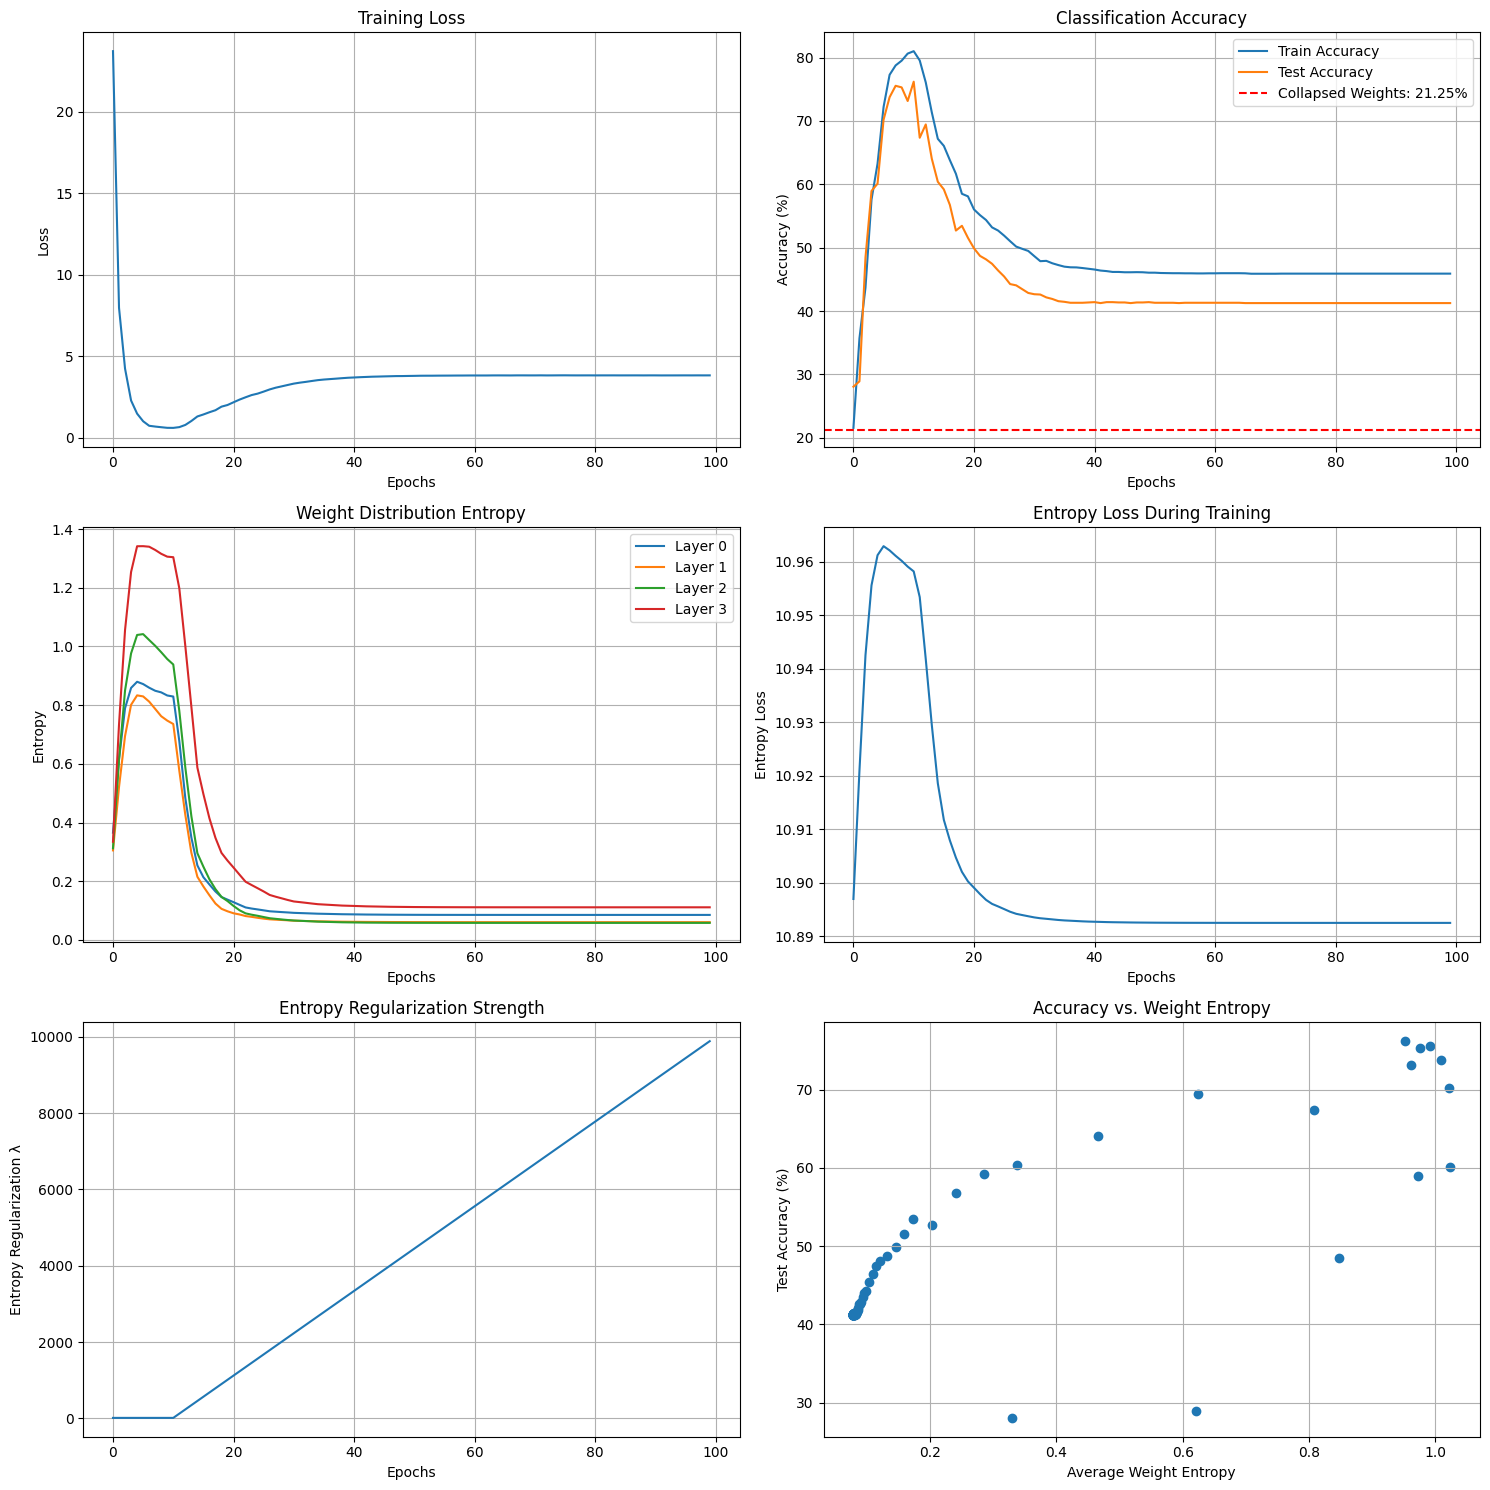

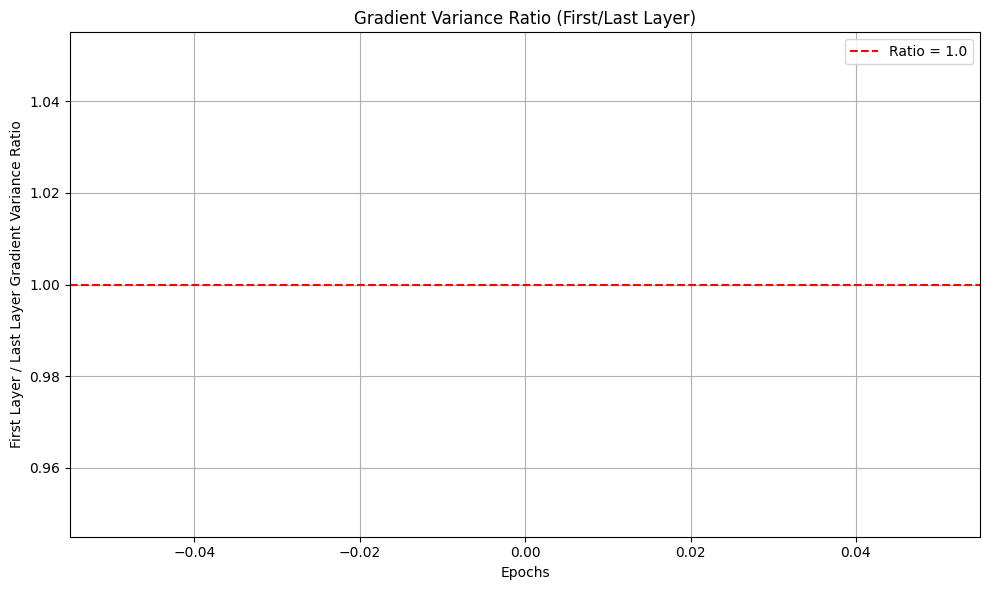


Most common operations by layer (after collapsing to one-hot):

model.0:
  A&~B (Op #2): 116 neurons
  ~A&B (Op #4): 95 neurons
  AND (Op #1): 62 neurons
  B (Op #5): 62 neurons
  False (Op #0): 58 neurons

model.1:
  A&~B (Op #2): 82 neurons
  ~A&B (Op #4): 76 neurons
  AND (Op #1): 73 neurons
  False (Op #0): 63 neurons
  NOR (Op #8): 63 neurons

model.2:
  NOR (Op #8): 85 neurons
  A&~B (Op #2): 79 neurons
  False (Op #0): 77 neurons
  ~A&B (Op #4): 75 neurons
  AND (Op #1): 73 neurons

model.3:
  NOR (Op #8): 89 neurons
  A&~B (Op #2): 88 neurons
  AND (Op #1): 85 neurons
  ~A&B (Op #4): 80 neurons
  False (Op #0): 54 neurons

Weight purity by layer (should be 1.0 after collapsing):
model.0: 1.0000
model.1: 1.0000
model.2: 1.0000
model.3: 1.0000

Verifying weights are on the simplex:
model.0 - Weight sums: min=1.000000, max=1.000000, mean=1.000000
model.1 - Weight sums: min=1.000000, max=1.000000, mean=1.000000
model.2 - Weight sums: min=1.000000, max=1.000000, mean=1.000000
model

In [ ]:
# Testing LogicGateNetwork with Entropy Regularization on MNIST
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.data import DataLoader, Subset
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load MNIST dataset and binarize the images
transform = transforms.Compose([
    transforms.ToTensor(),
    # We need to binarize the images since the logic gates work with boolean inputs
    transforms.Lambda(lambda x: (x > 0.5).float())
])

# Load MNIST dataset
train_set = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

# For faster testing, let's use a subset of the data
# Use 10% of training data (6000 examples)
num_train = len(train_set)
indices = list(range(num_train))
random.shuffle(indices)
subset_size = int(num_train * 0.1)  # 10% of the data
subset_indices = indices[:subset_size]
train_subset = Subset(train_set, subset_indices)

# Use 20% of test data (2000 examples)
num_test = len(test_set)
test_indices = list(range(num_test))
test_subset_size = int(num_test * 0.2)
test_subset_indices = test_indices[:test_subset_size]
test_subset = Subset(test_set, test_subset_indices)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Create a LogicGateNetwork for MNIST
# MNIST images are 28x28 = 784 pixels
input_dim = 28 * 28
num_classes = 10

# Create a model with fewer layers to reduce gradient flow issues
model = LogicGateNetwork(
    in_dim=input_dim,
    hidden_dims=[800, 800, 800, 800,800, 800],  # Four hidden layers (reduced from 12)
    num_classes=num_classes,
    device=device,
    connections='unique',  # Use unique connections to ensure better input coverage
    grad_factor=1.0,       # Use full gradients (no scaling)
    tau=0.1,               # Lower temperature for sharper decisions
    random_seed=42
)

# Mark weights for projection
model.mark_weights_for_projection()

# Analyze initial gradient variance before any training
print("\nAnalyzing initial gradient variance before training:")
# Find all logic layers
logic_layers = [module for name, module in model.named_modules() if isinstance(module, LogicLayer)]
initial_gradient_variances = {f'layer_{i}': 0.0 for i in range(len(logic_layers))}

# Create a sample batch to compute initial gradients
sample_batch, sample_targets = next(iter(train_loader))
sample_batch = sample_batch.view(sample_batch.size(0), -1).to(device)
sample_targets = sample_targets.to(device)

# Forward pass
model.train()  # Set to training mode to enable gradient tracking
criterion = torch.nn.CrossEntropyLoss()
outputs = model(sample_batch)
loss = criterion(outputs, sample_targets)

# Backward pass
loss.backward()

# Collect initial gradient variances
with torch.no_grad():
    for i, layer in enumerate(logic_layers):
        all_grads = []
        for param in layer.parameters():
            if param.grad is not None:
                all_grads.append(param.grad.flatten())

        if all_grads:
            all_grads = torch.cat(all_grads)
            initial_variance = torch.var(all_grads).item()
            initial_gradient_variances[f'layer_{i}'] = initial_variance
            print(f"  Layer {i} initial gradient variance: {initial_variance:.8f}")

# Calculate initial gradient variance ratio (first layer to last layer)
if len(logic_layers) > 1:
    first_layer_var = initial_gradient_variances['layer_0']
    last_layer_var = initial_gradient_variances[f'layer_{len(logic_layers)-1}']

    if last_layer_var > 0:
        initial_ratio = first_layer_var / last_layer_var
        print(f"\nInitial gradient variance ratio (first/last layer): {initial_ratio:.8f}")
        if initial_ratio < 0.1:
            print("  WARNING: Initial ratio is very low, indicating potential vanishing gradient issues")
        elif initial_ratio > 10:
            print("  WARNING: Initial ratio is very high, indicating potential exploding gradient issues")
        else:
            print("  Initial gradient ratio is in a healthy range")
    else:
        print("\nCannot calculate initial ratio: last layer has zero gradient variance")

# Zero out gradients before starting training
model.zero_grad()

# Create the projected optimizer
base_optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = SimplexProjectedOptimizer(base_optimizer)

# Create a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    base_optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

# Initialize entropy regularization scheduler
entropy_scheduler = EntropyRegScheduler(
    init_value=10.0,    # Start with mild regularization
    final_value=10000.0,    # Increase to moderate regularization
    epochs=100,           # Total training epochs
    warmup=10             # Let the model learn basic patterns first
)

# Training parameters
num_epochs = 100

# For tracking metrics
train_losses = []
train_accuracies = []
test_accuracies = []
entropy_losses = []
entropy_reg_values = []
weight_entropy_by_layer = {}

# Initialize weight entropy tracking
for name, module in model.named_modules():
    if isinstance(module, LogicLayer):
        weight_entropy_by_layer[name] = []

# For tracking gradient variances
gradient_variances = {}
# Extract logic layers from the model
logic_layers = [module for name, module in model.named_modules() if isinstance(module, LogicLayer)]
for i in range(len(logic_layers)):
    gradient_variances[f'layer_{i}'] = []

# Modified training loop with entropy regularization and gradient tracking
print(f"\nStarting training for {num_epochs} epochs with entropy regularization...")
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()

    # Update entropy regularization parameter
    current_entropy_reg = entropy_scheduler.step(epoch)
    entropy_reg_values.append(current_entropy_reg)

    # Train one epoch with entropy regularization
    train_loss, train_acc, entropy_loss = train_epoch(
        model, optimizer, train_loader, device, entropy_reg_lambda=current_entropy_reg
    )

    # Evaluate on test set
    test_acc = evaluate(model, test_loader, device)

    # Update learning rate scheduler
    scheduler.step(test_acc)

    # Record metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    entropy_losses.append(entropy_loss)

    # Track weight entropy for each layer
    for name, module in model.named_modules():
        if isinstance(module, LogicLayer):
            weights = module.weights.detach().cpu().numpy()
            # Avoid log(0) with small epsilon
            weights = np.clip(weights, 1e-10, 1.0)
            entropy = -np.sum(weights * np.log2(weights), axis=1).mean()

            # Make sure the entry exists
            if name not in weight_entropy_by_layer:
                weight_entropy_by_layer[name] = []

            weight_entropy_by_layer[name].append(entropy)

    # Print progress
    epoch_time = time.time() - epoch_start
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, '
          f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%, '
          f'Entropy Loss: {entropy_loss:.4f}, Reg λ: {current_entropy_reg:.4f}, '
          f'Time: {epoch_time:.2f}s')

total_time = time.time() - start_time
print(f"Training completed in {total_time:.2f} seconds")

# Collapse weights to one-hot for final evaluation
print("\nCollapsing weights to one-hot encodings...")
for name, module in model.named_modules():
    if isinstance(module, LogicLayer):
        with torch.no_grad():
            # Find the maximum weight for each neuron
            max_indices = torch.argmax(module.weights, dim=1)

            # Create one-hot encoded weights
            new_weights = torch.zeros_like(module.weights)
            for i, idx in enumerate(max_indices):
                new_weights[i, idx] = 1.0

            # Replace the weights with one-hot encoded weights
            module.weights.copy_(new_weights)

# Evaluate collapsed model
print("\nEvaluating model with collapsed (one-hot) weights:")
collapsed_test_acc = evaluate(model, test_loader, device)
print(f"Test accuracy with collapsed weights: {collapsed_test_acc:.2f}%")

# Plot training curves, entropy, and gradient variance
plt.figure(figsize=(15, 15))

# Plot 1: Loss
plt.subplot(3, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(3, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.axhline(y=collapsed_test_acc, color='r', linestyle='--',
          label=f'Collapsed Weights: {collapsed_test_acc:.2f}%')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Classification Accuracy')
plt.legend()
plt.grid(True)

# Plot 3: Weight Entropy Evolution
plt.subplot(3, 2, 3)
for name, entropy_values in weight_entropy_by_layer.items():
    layer_number = name.split('.')[-1] if '.' in name else name
    plt.plot(entropy_values, label=f'Layer {layer_number}')
plt.xlabel('Epochs')
plt.ylabel('Entropy')
plt.title('Weight Distribution Entropy')
plt.legend()
plt.grid(True)

# Plot 4: Entropy Loss
plt.subplot(3, 2, 4)
plt.plot(entropy_losses, label='Entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Entropy Loss')
plt.title('Entropy Loss During Training')
plt.grid(True)

# Plot 5: Entropy Regularization Lambda
plt.subplot(3, 2, 5)
plt.plot(entropy_reg_values, label='λ Value')
plt.xlabel('Epochs')
plt.ylabel('Entropy Regularization λ')
plt.title('Entropy Regularization Strength')
plt.grid(True)

# Plot 6: Test Accuracy vs. Weight Entropy
plt.subplot(3, 2, 6)
# Average entropy across all layers for each epoch
avg_entropy = np.zeros(len(test_accuracies))
for entropy_values in weight_entropy_by_layer.values():
    avg_entropy += np.array(entropy_values[:len(avg_entropy)])
avg_entropy /= len(weight_entropy_by_layer)

plt.scatter(avg_entropy, test_accuracies)
plt.xlabel('Average Weight Entropy')
plt.ylabel('Test Accuracy (%)')
plt.title('Accuracy vs. Weight Entropy')
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate gradient variance ratios to check for vanishing gradients
plt.figure(figsize=(10, 6))
# Count number of logic layers
logic_layers = [module for name, module in model.named_modules() if isinstance(module, LogicLayer)]
if len(logic_layers) > 1:
    # Calculate ratio of last layer variance to first layer variance
    first_layer_vars = gradient_variances['layer_0']
    last_layer_vars = gradient_variances[f'layer_{len(logic_layers)-1}']

    # Avoid division by zero
    ratios = []
    for i in range(len(first_layer_vars)):
        if last_layer_vars[i] > 0:  # Changed to check last_layer_vars to avoid div by zero
            ratios.append(first_layer_vars[i]/last_layer_vars[i])
        else:
            ratios.append(np.nan)  # Mark as NaN if division by zero

    plt.plot(ratios, marker='o')
    plt.axhline(y=1.0, color='r', linestyle='--', label='Ratio = 1.0')
    plt.xlabel('Epochs')
    plt.ylabel('First Layer / Last Layer Gradient Variance Ratio')
    plt.title('Gradient Variance Ratio (First/Last Layer)')
    plt.grid(True)
    plt.legend()

    # Print the average ratio
    valid_ratios = [r for r in ratios if not np.isnan(r)]
    if valid_ratios:
        avg_ratio = np.mean(valid_ratios)
        print(f"\nAverage gradient variance ratio (First/Last layer): {avg_ratio:.6f}")
        print(f"Ratios close to 0 indicate vanishing gradients, ratios >> 1 suggest exploding gradients")

plt.tight_layout()
plt.show()

# Analyze gate operations
gate_operations, entropy = analyze_weights(model)

# Convert gate numbers to operation names for better interpretability
op_names = {
    0: "False", 1: "AND", 2: "A&~B", 3: "A",
    4: "~A&B", 5: "B", 6: "XOR", 7: "OR",
    8: "NOR", 9: "XNOR", 10: "~B", 11: "A|~B",
    12: "~A", 13: "~A|B", 14: "NAND", 15: "True"
}

# Analyze the most common operations in each layer
print("\nMost common operations by layer (after collapsing to one-hot):")
for layer, ops in gate_operations.items():
    # Sort operations by frequency
    sorted_ops = sorted(ops.items(), key=lambda x: x[1], reverse=True)

    # Print the top 5 operations
    print(f"\n{layer}:")
    for op, count in sorted_ops[:5]:
        op_name = op_names[op]
        print(f"  {op_name} (Op #{op}): {count} neurons")

# Check purity of weights (should be exactly 1.0 after collapsing)
print("\nWeight purity by layer (should be 1.0 after collapsing):")
for name, module in model.named_modules():
    if isinstance(module, LogicLayer):
        weights = module.weights.detach().cpu()

        # Calculate purity as the maximum weight value
        purity = weights.max(dim=1)[0].mean().item()

        print(f"{name}: {purity:.4f}")

# Verify weights still sum to 1
print("\nVerifying weights are on the simplex:")
for name, module in model.named_modules():
    if isinstance(module, LogicLayer):
        weights = module.weights.detach().cpu()
        weight_sums = weights.sum(dim=1)

        print(f"{name} - Weight sums: min={weight_sums.min().item():.6f}, "
              f"max={weight_sums.max().item():.6f}, "
              f"mean={weight_sums.mean().item():.6f}")

# Optional: Test accuracy vs. entropy regularization strength experiment
def run_entropy_reg_experiment(strength_values):
    """Run multiple training runs with different entropy regularization strengths."""
    results = []

    for strength in strength_values:
        print(f"\n\nTesting entropy regularization strength: {strength}")

        # Create a fresh model
        model = LogicGateNetwork(
            in_dim=input_dim,
            hidden_dims=[800, 800, 800, 800],
            num_classes=num_classes,
            device=device,
            connections='unique',
            grad_factor=1.0,
            tau=0.1,
            random_seed=42
        )

        model.mark_weights_for_projection()

        # Create optimizer
        base_optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        optimizer = SimplexProjectedOptimizer(base_optimizer)

        # Training for fewer epochs to save time
        test_epochs = 20

        # Fixed entropy regularization
        entropy_reg = strength

        # Track metrics
        test_accs = []
        final_entropy = 0

        # Quick training loop
        for epoch in range(test_epochs):
            # Train with fixed entropy regularization
            train_loss, train_acc, entropy_loss = train_epoch(
                model, optimizer, train_loader, device, entropy_reg_lambda=entropy_reg
            )

            # Test
            test_acc = evaluate(model, test_loader, device)
            test_accs.append(test_acc)

            print(f'Epoch {epoch+1}/{test_epochs}, Test Acc: {test_acc:.2f}%')

        # Collapse weights
        for name, module in model.named_modules():
            if isinstance(module, LogicLayer):
                with torch.no_grad():
                    max_indices = torch.argmax(module.weights, dim=1)
                    new_weights = torch.zeros_like(module.weights)
                    for i, idx in enumerate(max_indices):
                        new_weights[i, idx] = 1.0
                    module.weights.copy_(new_weights)

        # Measure final entropy before collapse
        total_entropy = 0
        count = 0
        for name, module in model.named_modules():
            if isinstance(module, LogicLayer):
                weights = module.weights.detach().cpu().numpy()
                weights = np.clip(weights, 1e-10, 1.0)
                layer_entropy = -np.sum(weights * np.log(weights), axis=1).mean()
                total_entropy += layer_entropy
                count += 1

        if count > 0:
            final_entropy = total_entropy / count

        # Test collapsed model
        collapsed_acc = evaluate(model, test_loader, device)

        results.append({
            'strength': strength,
            'final_test_acc': test_accs[-1],
            'collapsed_test_acc': collapsed_acc,
            'final_entropy': final_entropy
        })

        print(f"Strength {strength}: Final Test Acc={test_accs[-1]:.2f}%, Collapsed={collapsed_acc:.2f}%")

    return results


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.data import DataLoader, Subset
import random

# -------------------------------
# Experiment Setup: MNIST with Entropy Regularization and Partial Rounding
# -------------------------------

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load MNIST dataset and binarize the images
transform = transforms.Compose([
    transforms.ToTensor(),
    # Binarize the images since the logic gates work with boolean inputs
    transforms.Lambda(lambda x: (x > 0.5).float())
])

train_set = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

# Use subsets for faster testing: 10% of train (6000 examples) and 20% of test (2000 examples)
num_train = len(train_set)
indices = list(range(num_train))
random.shuffle(indices)
subset_size = int(num_train * 1)
subset_indices = indices[:subset_size]
train_subset = Subset(train_set, subset_indices)

num_test = len(test_set)
test_indices = list(range(num_test))
test_subset_size = int(num_test)
test_subset_indices = test_indices[:test_subset_size]
test_subset = Subset(test_set, test_subset_indices)

train_loader = DataLoader(train_subset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=512, shuffle=False)

# Create a LogicGateNetwork for MNIST (28x28 = 784 pixels)
input_dim = 28 * 28
num_classes = 10

model = LogicGateNetwork(
    in_dim=input_dim,
    hidden_dims=[8000, 8000, 8000, 8000, 8000, 8000],
    num_classes=num_classes,
    device=device,
    connections='unique',
    grad_factor=1.0,
    tau=0.1,
    random_seed=42
)

model.mark_weights_for_projection()

# -------------------------------
# Initial Gradient Analysis (unchanged)
# -------------------------------
print("\nAnalyzing initial gradient variance before training:")
logic_layers = [module for name, module in model.named_modules() if isinstance(module, LogicLayer)]
initial_gradient_variances = {f'layer_{i}': 0.0 for i in range(len(logic_layers))}

sample_batch, sample_targets = next(iter(train_loader))
sample_batch = sample_batch.view(sample_batch.size(0), -1).to(device)
sample_targets = sample_targets.to(device)

model.train()
criterion = torch.nn.CrossEntropyLoss()
outputs = model(sample_batch)
loss = criterion(outputs, sample_targets)
loss.backward()

with torch.no_grad():
    for i, layer in enumerate(logic_layers):
        all_grads = []
        for param in layer.parameters():
            if param.grad is not None:
                all_grads.append(param.grad.flatten())
        if all_grads:
            all_grads = torch.cat(all_grads)
            initial_variance = torch.var(all_grads).item()
            initial_gradient_variances[f'layer_{i}'] = initial_variance
            print(f"  Layer {i} initial gradient variance: {initial_variance:.8f}")

if len(logic_layers) > 1:
    first_layer_var = initial_gradient_variances['layer_0']
    last_layer_var = initial_gradient_variances[f'layer_{len(logic_layers)-1}']
    if last_layer_var > 0:
        initial_ratio = first_layer_var / last_layer_var
        print(f"\nInitial gradient variance ratio (first/last layer): {initial_ratio:.8f}")
        if initial_ratio < 0.1:
            print("  WARNING: Initial ratio is very low, indicating potential vanishing gradient issues")
        elif initial_ratio > 10:
            print("  WARNING: Initial ratio is very high, indicating potential exploding gradient issues")
        else:
            print("  Initial gradient ratio is in a healthy range")
    else:
        print("\nCannot calculate initial ratio: last layer has zero gradient variance")

model.zero_grad()

# -------------------------------
# Optimizer, Scheduler, and Entropy Scheduler Setup
# -------------------------------
base_optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = SimplexProjectedOptimizer(base_optimizer)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    base_optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

entropy_scheduler = EntropyRegScheduler(
    init_value=0.0,    # Starting with mild regularization
    final_value=0.0,  # Increase to stronger regularization
    epochs=100,
    warmup=10
)

# -------------------------------
# Training Loop with Entropy Penalty and Partial Rounding
# -------------------------------
num_epochs = 1000
# Set partial rounding parameters:
rounding_interval = 1000000       # every 20 epochs perform partial rounding
entropy_threshold = 0.0      # threshold for low-entropy (adjust as needed)

# For tracking metrics
train_losses = []
train_accuracies = []
test_accuracies = []
entropy_losses = []
entropy_reg_values = []
weight_entropy_by_layer = {}

for name, module in model.named_modules():
    if isinstance(module, LogicLayer):
        weight_entropy_by_layer[name] = []

gradient_variances = {}
for i in range(len(logic_layers)):
    gradient_variances[f'layer_{i}'] = []

print(f"\nStarting training for {num_epochs} epochs with entropy regularization and partial rounding...")
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()

    current_entropy_reg = entropy_scheduler.step(epoch)
    entropy_reg_values.append(current_entropy_reg)

    train_loss, train_acc, entropy_loss = train_epoch(
        model, optimizer, train_loader, device, entropy_reg_lambda=current_entropy_reg
    )

    test_acc = evaluate(model, test_loader, device)
    scheduler.step(test_acc)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    entropy_losses.append(entropy_loss)

    # Track weight entropy for each LogicLayer (without applying softmax)
    for name, module in model.named_modules():
        if isinstance(module, LogicLayer):
            weights = module.weights.detach().cpu().numpy()
            weights = np.clip(weights, 1e-10, 1.0)
            layer_entropy = -np.sum(weights * np.log2(weights), axis=1).mean()
            weight_entropy_by_layer[name].append(layer_entropy)

    # Every rounding_interval epochs, perform partial rounding
    if (epoch + 1) % rounding_interval == 0:
        print(f"Performing partial rounding at epoch {epoch+1}...")
        partial_round_and_freeze(model, entropy_threshold)

    epoch_time = time.time() - epoch_start
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, '
          f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%, '
          f'Entropy Loss: {entropy_loss:.4f}, Reg λ: {current_entropy_reg:.4f}, '
          f'Time: {epoch_time:.2f}s')

total_time = time.time() - start_time
print(f"Training completed in {total_time:.2f} seconds")

# -------------------------------
# Final Full Rounding (Collapse) and Evaluation
# -------------------------------
print("\nCollapsing weights to one-hot encodings...")
for name, module in model.named_modules():
    if isinstance(module, LogicLayer):
        with torch.no_grad():
            max_indices = torch.argmax(module.weights, dim=1)
            new_weights = torch.zeros_like(module.weights)
            for i, idx in enumerate(max_indices):
                new_weights[i, idx] = 1.0
            module.weights.copy_(new_weights)

print("\nEvaluating model with collapsed (one-hot) weights:")
collapsed_test_acc = evaluate(model, test_loader, device)
print(f"Test accuracy with collapsed weights: {collapsed_test_acc:.2f}%")

# -------------------------------
# Plotting Results
# -------------------------------
plt.figure(figsize=(15, 15))

plt.subplot(3, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.axhline(y=collapsed_test_acc, color='r', linestyle='--',
            label=f'Collapsed Weights: {collapsed_test_acc:.2f}%')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Classification Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 3)
for name, entropy_values in weight_entropy_by_layer.items():
    layer_number = name.split('.')[-1] if '.' in name else name
    plt.plot(entropy_values, label=f'Layer {layer_number}')
plt.xlabel('Epochs')
plt.ylabel('Entropy')
plt.title('Weight Distribution Entropy')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot(entropy_losses, label='Entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Entropy Loss')
plt.title('Entropy Loss During Training')
plt.grid(True)

plt.subplot(3, 2, 5)
plt.plot(entropy_reg_values, label='λ Value')
plt.xlabel('Epochs')
plt.ylabel('Entropy Regularization λ')
plt.title('Entropy Regularization Strength')
plt.grid(True)

plt.subplot(3, 2, 6)
avg_entropy = np.zeros(len(test_accuracies))
for entropy_values in weight_entropy_by_layer.values():
    avg_entropy += np.array(entropy_values[:len(avg_entropy)])
avg_entropy /= len(weight_entropy_by_layer)
plt.scatter(avg_entropy, test_accuracies)
plt.xlabel('Average Weight Entropy')
plt.ylabel('Test Accuracy (%)')
plt.title('Accuracy vs. Weight Entropy')
plt.grid(True)

plt.tight_layout()
plt.show()

# -------------------------------
# (Optional) Experiment: Test accuracy vs. entropy regularization strength with partial rounding
# -------------------------------
def run_entropy_reg_experiment(strength_values):
    """Run multiple training runs with different entropy regularization strengths and include partial rounding."""
    results = []
    for strength in strength_values:
        print(f"\n\nTesting entropy regularization strength: {strength}")
        model = LogicGateNetwork(
            in_dim=input_dim,
            hidden_dims=[800, 800, 800, 800],
            num_classes=num_classes,
            device=device,
            connections='unique',
            grad_factor=1.0,
            tau=0.1,
            random_seed=42
        )
        model.mark_weights_for_projection()
        base_optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        optimizer = SimplexProjectedOptimizer(base_optimizer)
        test_epochs = 20
        entropy_reg = strength
        test_accs = []
        for epoch in range(test_epochs):
            train_loss, train_acc, _ = train_epoch(model, optimizer, train_loader, device, entropy_reg_lambda=entropy_reg)
            test_acc = evaluate(model, test_loader, device)
            test_accs.append(test_acc)
            # Also perform partial rounding every 10 epochs in this experiment run
            if (epoch + 1) % 10 == 0:
                partial_round_and_freeze(model, entropy_threshold)
            print(f'Epoch {epoch+1}/{test_epochs}, Test Acc: {test_acc:.2f}%')
        # Collapse remaining weights
        for name, module in model.named_modules():
            if isinstance(module, LogicLayer):
                with torch.no_grad():
                    max_indices = torch.argmax(module.weights, dim=1)
                    new_weights = torch.zeros_like(module.weights)
                    for i, idx in enumerate(max_indices):
                        new_weights[i, idx] = 1.0
                    module.weights.copy_(new_weights)
        total_entropy = 0
        count = 0
        for name, module in model.named_modules():
            if isinstance(module, LogicLayer):
                weights = module.weights.detach().cpu().numpy()
                weights = np.clip(weights, 1e-10, 1.0)
                layer_entropy = -np.sum(weights * np.log(weights), axis=1).mean()
                total_entropy += layer_entropy
                count += 1
        final_entropy = total_entropy / count if count > 0 else 0
        collapsed_acc = evaluate(model, test_loader, device)
        results.append({
            'strength': strength,
            'final_test_acc': test_accs[-1],
            'collapsed_test_acc': collapsed_acc,
            'final_entropy': final_entropy
        })
        print(f"Strength {strength}: Final Test Acc={test_accs[-1]:.2f}%, Collapsed={collapsed_acc:.2f}%")
    return results

Using device: cuda

Analyzing initial gradient variance before training:
  Layer 0 initial gradient variance: 0.53883624
  Layer 1 initial gradient variance: 0.59048945
  Layer 2 initial gradient variance: 0.66164362
  Layer 3 initial gradient variance: 0.72567368
  Layer 4 initial gradient variance: 0.79264295
  Layer 5 initial gradient variance: 0.89536858

Initial gradient variance ratio (first/last layer): 0.60180383
  Initial gradient ratio is in a healthy range

Starting training for 1000 epochs with entropy regularization and partial rounding...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/1000, Loss: 43.8068, Train Acc: 41.37%, Test Acc: 52.95%, Entropy Loss: 2.3852, Reg λ: 0.0000, Time: 37.72s
Epoch 2/1000, Loss: 17.5036, Train Acc: 57.77%, Test Acc: 65.86%, Entropy Loss: 4.2865, Reg λ: 0.0000, Time: 37.47s
Epoch 3/1000, Loss: 6.2799, Train Acc: 71.43%, Test Acc: 79.96%, Entropy Loss: 5.0024, Reg λ: 0.0000, Time: 38.41s
Epoch 4/1000, Loss: 2.5833, Train Acc: 81.98%, Test Acc: 84.51%, Entropy Loss: 5.2805, Reg λ: 0.0000, Time: 37.92s
Epoch 5/1000, Loss: 1.3792, Train Acc: 86.26%, Test Acc: 90.34%, Entropy Loss: 5.4201, Reg λ: 0.0000, Time: 37.87s
Epoch 6/1000, Loss: 1.1318, Train Acc: 87.32%, Test Acc: 92.68%, Entropy Loss: 5.5165, Reg λ: 0.0000, Time: 38.05s
Epoch 7/1000, Loss: 0.4785, Train Acc: 91.70%, Test Acc: 85.71%, Entropy Loss: 5.5901, Reg λ: 0.0000, Time: 37.94s
Epoch 8/1000, Loss: 0.5359, Train Acc: 90.84%, Test Acc: 92.27%, Entropy Loss: 5.6270, Reg λ: 0.0000, Time: 37.88s
Epoch 9/1000, Loss: 0.2691, Train Acc: 93.76%, Test Acc: 93.05%, Entropy Loss: